In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.download("/content/mvtec.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import os
import numpy as np
import random
import warnings
import argparse
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, History

warnings.simplefilter("ignore")


In [ ]:
def architecture_MVTEC(input_shape=(128, 128, 1), latent_dim=100):

    parameters = dict()
    N_layers = 9
    parameters["filters"] = [32, 32, 32, 64, 64, 128, 64, 32, latent_dim]
    parameters["kernel_size"] = [4, 4, 3, 4, 3, 4, 3, 3, 8]
    parameters["strides"] = [2, 2, 1, 2, 1, 2, 1, 1, 1]
    parameters["padding"] = ["same" for _ in range(N_layers-1)] + ["valid"]

    # Input
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    for i in range(0, N_layers):
        x = Conv2D(
          filters=parameters["filters"][i],
          kernel_size=parameters["kernel_size"][i],
          strides=parameters["strides"][i],
          padding=parameters["padding"][i])(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    for i in reversed(range(0, N_layers)):
        x = Conv2DTranspose(
          filters=parameters["filters"][i],
          kernel_size=parameters["kernel_size"][i],
          strides=parameters["strides"][i],
          padding=parameters["padding"][i])(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Output
    x = Conv2DTranspose(
      filters=input_shape[2],
      kernel_size=(3, 3),
      strides=(1, 1),
      padding="same")(x)

    outputs = x

    # Autoencoder
    autoencoder = Model(inputs, outputs, name="autoencoder")

    return autoencoder




In [ ]:
cd /content/drive/MyDrive/final

/content/drive/MyDrive/final


In [ ]:
def read_data(dataset_name="capsule"):

    path_to_train_set = f"MVTEC/{dataset_name}/train/"
    path_to_test_set = f"MVTEC/{dataset_name}/test/"

    train_data = dict()
    test_data = dict()

    ROI_extracted_size = (256, 256)
    ROI_resized_size = (128, 128)

    for path_to_data, data_dict in [(path_to_train_set, train_data), (path_to_test_set, test_data)]:
        for category in tqdm(os.listdir(path_to_data)):
            for img_name in tqdm(os.listdir(path_to_data + str(category))):

                img = cv2.imread(f"{path_to_data}{category}/{img_name}", 0)
                for x_start in range(0, img.shape[0]-ROI_extracted_size[0]+1, ROI_extracted_size[0]):
                    for y_start in range(0, img.shape[1]-ROI_extracted_size[1]+1, ROI_extracted_size[1]):

                        x_end = x_start + ROI_extracted_size[0]
                        y_end = y_start + ROI_extracted_size[1]

                        img_ROI = img[x_start:x_end, y_start:y_end]
                        img_resized = cv2.resize(img_ROI, ROI_resized_size)
                        img_resized = img_resized.astype("float32") / 255.0

                        if category not in data_dict:
                            data_dict[category] = dict()
                        if img_name not in data_dict[category]:
                            data_dict[category][img_name] = []
                        data_dict[category][img_name].append(img_resized)

    return train_data, test_data





In [ ]:
def read_data_with_random_crop(dataset_name="capsule", N_train=10**4):

    path_to_train_set = f"MVTEC/{dataset_name}/train/"

    if dataset_name in ["texture_1", "texture_2"]:
        img_resized_size = (256, 256)
        crop_size = (128, 128)
    elif dataset_name in ["carpet", "grid","crew", "hazelnut"]:
        img_resized_size = (512, 512)
        crop_size = (128, 128)

    train_data = []

    for i in tqdm(range(0, N_train)):

        img_name = random.choice(list(os.listdir(path_to_train_set + "good")))
        img = cv2.imread(f"{path_to_train_set}good/{img_name}", 0)
        img_resized = cv2.resize(img, img_resized_size)
        x_start = random.randint(0, img_resized.shape[0]-crop_size[0])
        y_start = random.randint(0, img_resized.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        crop = img_resized[x_start:x_end, y_start:y_end]
        crop = crop.astype("float32") / 255.0
        train_data.append(crop)

    X_train = np.array(train_data)

    return X_train

In [ ]:
def DSSIM_loss(y_true, y_pred):
    return 1/2 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))/2

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
          # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

def train_model(input_shape=(128, 128, 1), dataset_name="capsule", latent_dim=100, training_loss="ssim", load_model=True, random_crop=False, batch_size=8, epoch = 100, N_train = 1000):

    # 1) read data
    if random_crop:
        X_train = read_data_with_random_crop(dataset_name=dataset_name, N_train= N_train)
        X_train = np.expand_dims(X_train, axis=-1)
    else:
        train_data, _ = read_data(dataset_name=dataset_name)
        X_train = []
        for img_name in train_data['good'].keys():
            for img in train_data['good'][img_name]:
                X_train.append(img)
        X_train = np.array(X_train)
        X_train = np.expand_dims(X_train, axis=-1)

    Y_train = X_train
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

    # 2) create autoencoder
    autoencoder = architecture_MVTEC(input_shape=input_shape, latent_dim=latent_dim)
    autoencoder.summary()

    # 3) choose training_loss function and optimizer
    opt = Adam(learning_rate=2*10e-5)

    if training_loss == "mse":
        autoencoder.compile(loss="mse", optimizer=opt)
    elif training_loss == "ssim":
        autoencoder.compile(loss=DSSIM_loss, optimizer=opt)

    # 4) set callbacks

    if not os.path.exists(f"model_weights/{dataset_name}/"):
        os.mkdir(f"model_weights/{dataset_name}/")

    path_to_save_model = f"model_weights/{dataset_name}/"
    name = f"a_{latent_dim}_loss_{training_loss}_batch_{batch_size}.hdf5"
    path_to_save_model += name

    model_checkpoint_callback = ModelCheckpoint(
      save_weights_only=False, filepath=path_to_save_model,
      monitor='val_loss', save_best_only=True)
    early_stopping_callback = EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

    # Added History callback to record loss values during training
    history_callback = History()

    # 5) load weights and training model
    if load_model:
        if name in os.listdir(f"model_weights/{dataset_name}"):
            autoencoder.load_weights(path_to_save_model)
    epoch = epoch
    history = autoencoder.fit(
      x=X_train, y=Y_train,
      epochs=epoch, batch_size=batch_size,
      shuffle=True, validation_data=(X_val, Y_val),
      callbacks=[model_checkpoint_callback, early_stopping_callback, history_callback])

    # Plotting learning curves
    plot_learning_curves(history)



In [ ]:
## Train with MSE loss
training_loss = "mse"
load_model = 0
random_crop = 1
latent_dim = 100

######
dataset_name = "hazelnut"
batch_size = 32
epoch = 200
N_train = 10000

train_model(
     input_shape=(128, 128, 1), dataset_name=dataset_name,
     latent_dim=latent_dim, training_loss=training_loss,
     load_model=load_model, random_crop=random_crop,
     batch_size=batch_size, epoch = epoch, N_train= N_train)

  0%|          | 4/10000 [00:06<4:39:35,  1.68s/it]


KeyboardInterrupt: ignored

100%|██████████| 10000/10000 [10:46<00:00, 15.47it/s]


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        544       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 32)        

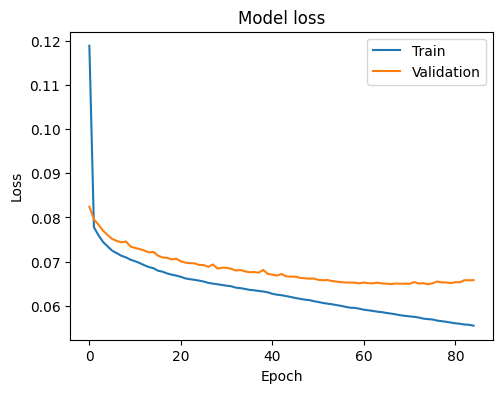

In [ ]:
## Train with SSIM loss
training_loss = "ssim"
load_model = 0
random_crop = 1
latent_dim = 100

######
dataset_name = "hazelnut"
batch_size = 32
epoch = 200
N_train = 10000

train_model(
     input_shape=(128, 128, 1), dataset_name=dataset_name,
     latent_dim=latent_dim, training_loss=training_loss,
     load_model=load_model, random_crop=random_crop,
     batch_size=batch_size, epoch = epoch, N_train= N_train)

In [ ]:
########## Evaluation Code ############

In [ ]:
import os
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from AE_training import architecture_MVTEC

plt.rc('font', size=12)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title


def calculate_TP_TN_FP_FN(ground_truth, predicted_mask):
    TP = np.sum(np.multiply((ground_truth == predicted_mask), predicted_mask == 1))
    TN = np.sum(np.multiply((ground_truth == predicted_mask), predicted_mask == 0))
    FP = np.sum(np.multiply((ground_truth != predicted_mask), predicted_mask == 1))
    FN = np.sum(np.multiply((ground_truth != predicted_mask), predicted_mask == 0))
    return TP, TN, FP, FN


def AP(TP, TN, FP, FN):
    return (TP+TN)/(TP+TN+FP+FN)


def DICE(TP, TN, FP, FN):
    if (2*TP+FP+FN) == 0:
        return 1
    else:
        return (2*TP)/(2*TP+FP+FN)


def FPR(TP, TN, FP, FN):
    return FP/(FP+TN)


def TPR(TP, TN, FP, FN):
    return TP/(TP+FN)

def PRE(TP, TN, FP, FN):
    return TP/(TP+FP)


def Youden_statistic(TP, TN, FP, FN):
    if (TP+FN) == 0 or (TN+FP) == 0:
        return None
    else:
        return TP/(TP+FN) + TN/(TN+FP) - 1


def calculate_AUC(ROC_curve):
    AUC = 0
    FPR_values = [x[0] for x in ROC_curve]
    TPR_values = [x[1] for x in ROC_curve]
    for i in range(0, len(FPR_values)-1):
        a = TPR_values[i]
        b = TPR_values[i+1]
        h = FPR_values[i+1]-FPR_values[i]
        AUC += (a+b)*h/2
    return AUC


def plot_ROC_curve(datasets, results):
    plt.clf()
    for metric_results in results:
        FPR_values = [x[1] for x in metric_results["FPR"]]
        TPR_values = [x[1] for x in metric_results["TPR"]]
        plt.plot(FPR_values, TPR_values, "-o")
    plt.xlim(0, 1)
    plt.xlabel("FPR", fontsize=12)
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(datasets)
    plt.grid()
    plt.savefig("ROC_curve.png")


def plot_YoundStat_thresh(datasets, results):
    plt.clf()
    for metric_results in results:
        YoundStat_values = [x[1] for x in metric_results["YoundenStat"]]
        thresh_values = [x[0] for x in metric_results["YoundenStat"]]
        plt.plot(thresh_values, YoundStat_values, "-o")
    plt.xlabel("Threshold")
    plt.ylabel("Younden's Statistic")
    plt.title("Younden's Statistic (Threshold)")
    plt.legend(datasets)
    plt.grid()
    plt.savefig("YoundStat_thresh.png")


def plot_DICE_thresh(datasets, results):
    plt.clf()
    for metric_results in results:
        DICE_values = [x[1] for x in metric_results["DICE"]]
        thresh_values = [x[0] for x in metric_results["DICE"]]
        plt.plot(thresh_values, DICE_values, "-o")
    plt.xlabel("Threshold")
    plt.ylabel("DICE")
    plt.title("DICE (Threshold)")
    plt.legend(datasets)
    plt.grid()
    plt.savefig("DICE_thresh.png")


def read_data_test(dataset):

    img_oryg_samples = []
    img_predict_samples = []
    ground_truth_samples = []

    for category in tqdm(os.listdir(f"MVTEC/{dataset}/test/")):
        if category == "good":
            continue
        for img_name in os.listdir(f"MVTEC/{dataset}/test/{category}/"):
            img_predict = cv2.imread(f"results/{dataset}/predicted/{category}/{img_name}", 0)

            img_oryg = cv2.imread(f"MVTEC/{dataset}/test/{category}/{img_name}", 0)

        if dataset in ["texture_1", "texture_2"]:
            ground_truth = cv2.imread(f"MVTEC/{dataset}/ground_truth/{category}/{img_name}", 0)
        else:
            ground_truth = cv2.imread(f"MVTEC/{dataset}/ground_truth/{category}/{img_name[:-4]}_mask.png", 0)
        ground_truth = (ground_truth > 0).astype(int)

        img_oryg_samples.append(img_oryg)
        img_predict_samples.append(img_predict)
        ground_truth_samples.append(ground_truth)

    return img_oryg_samples, img_predict_samples, ground_truth_samples


def calculate_loss(img_oryg_samples, img_predict_samples, win_size=11):

    loss_samples = []
    n = len(img_oryg_samples)
    for i in range(0, n):
        img_oryg = img_oryg_samples[i].astype("float32") / 255.0
        img_predict = img_predict_samples[i].astype("float32") / 255.0
        _, S = ssim(
            img_oryg, img_predict, data_range=1, gradient=False, full=True, multichannel=False, win_size=win_size)
        loss = 1/2 - S/2
        loss_samples.append(loss)

    return loss_samples


def calculate_metrics(loss_samples, ground_truth_samples, thresh_max=1):
    metric_results = dict()
    metric_results["DICE"] = []
    metric_results["YoundenStat"] = []
    metric_results["TPR"] = []
    metric_results["FPR"] = []
    metric_results["Accuracy"] = []
    metric_results["Precision"] = []
    metric_results["Recall"] = []
    metric_results["F1_Score"] = []

    thresh_min = 0
    thresh_values = np.linspace(thresh_min, thresh_max, num=100) ** 2
    thresh_values = [x for x in thresh_values]

    for thresh in thresh_values:
        Dice_values = []
        YoundenStat_values = []
        TPR_values = []
        FPR_values = []
        Accuracy_values = []
        Precision_values = []
        Recall_values = []
        F1_Score_values = []

        n = len(loss_samples)
        for i in range(0, n):
            predicted_mask = (loss_samples[i] > thresh).astype(int)
            ground_truth = ground_truth_samples[i]
            TP, TN, FP, FN = calculate_TP_TN_FP_FN(ground_truth=ground_truth, predicted_mask=predicted_mask)

            Dice_values.append(DICE(TP, TN, FP, FN))
            YoundenStat_values.append(Youden_statistic(TP, TN, FP, FN))
            TPR_values.append(TPR(TP, TN, FP, FN))
            FPR_values.append(FPR(TP, TN, FP, FN))

            # Calculate additional metrics using TP, FP, TN, FN
            Accuracy_values.append((TP + TN) / (TP + TN + FP + FN))
            Precision_values.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
            Recall_values.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
            F1_Score_values.append(2 * (Precision_values[-1] * Recall_values[-1]) / (Precision_values[-1] + Recall_values[-1]) if (Precision_values[-1] + Recall_values[-1]) != 0 else 0)

        metric_results["DICE"].append((thresh, np.mean(Dice_values)))
        metric_results["YoundenStat"].append((thresh, np.mean(YoundenStat_values)))
        metric_results["TPR"].append((thresh, np.mean(TPR_values)))
        metric_results["FPR"].append((thresh, np.mean(FPR_values)))
        metric_results["Accuracy"].append((thresh, np.mean(Accuracy_values)))
        metric_results["Precision"].append((thresh, np.mean(Precision_values)))
        metric_results["Recall"].append((thresh, np.mean(Recall_values)))
        metric_results["F1_Score"].append((thresh, np.mean(F1_Score_values)))


        # metric_results["DICE"].append((thresh, Dice_values[-1]))
        # metric_results["YoundenStat"].append((thresh, YoundenStat_values[-1]))
        # metric_results["TPR"].append((thresh, TPR_values[-1]))
        # metric_results["FPR"].append((thresh, FPR_values[-1]))
        # metric_results["Accuracy"].append((thresh, Accuracy_values[-1]))
        # metric_results["Precision"].append((thresh, Precision_values[-1]))
        # metric_results["Recall"].append((thresh, Recall_values[-1]))
        # metric_results["F1_Score"].append((thresh, F1_Score_values[-1]))

  #  # Find the optimum threshold based on maximum YoundenStat
  #   YoundenStat_values = [x[1] for x in metric_results["YoundenStat"]]
  #   optimal_thresh_index = np.argmax(YoundenStat_values)
  #   optimal_thresh = metric_results["YoundenStat"][optimal_thresh_index][0]

     # Find the optimum threshold based on maximum F1 Score
    F1_values = [x[1] for x in metric_results["F1_Score"]]
    optimal_thresh_index = np.argmax(F1_values)
    optimal_thresh = metric_results["F1_Score"][optimal_thresh_index][0]

    # Report metrics at the optimum threshold
    optimal_metrics = {
        "Accuracy": metric_results["Accuracy"][optimal_thresh_index][1],
        "Precision": metric_results["Precision"][optimal_thresh_index][1],
        "Recall": metric_results["Recall"][optimal_thresh_index][1],
        "F1_Score": metric_results["F1_Score"][optimal_thresh_index][1],
        "YoundenStat": metric_results["YoundenStat"][optimal_thresh_index][1]
    }


    DICE_max_thresh, DICE_max = max(metric_results["DICE"], key=lambda x: x[1])

    YoundenStat_max_thresh, YoundenStat_max = max(metric_results["YoundenStat"], key=lambda x: x[1])

    ROC_curve = list(zip([x[1] for x in metric_results["FPR"]], [x[1] for x in metric_results["TPR"]]))
    ROC_curve = sorted(ROC_curve, key=lambda x: x[0])
    AUC = calculate_AUC(ROC_curve)

    return metric_results, DICE_max, YoundenStat_max, AUC, optimal_thresh, optimal_metrics


def create_predicted(dataset_name="carpet", latent_dim=100, training_loss="ssim", batch_size=32):

    autoencoder = architecture_MVTEC(input_shape=(128, 128, 1), latent_dim=latent_dim)
    path_to_load_model = f"model_weights/{dataset_name}/"
    name = f"a_{latent_dim}_loss_{training_loss}_batch_{batch_size}.hdf5"
    path_to_load_model += name
    autoencoder.load_weights(path_to_load_model)

    if dataset_name in ["texture_1", "texture_2"]:
        img_in_size = (512, 512)
        img_resized_size = (256, 256)
        crop_size = (128, 128)
        step = 16
    elif dataset_name in ["carpet", "grid","crew", "hazelnut"]:
        img_in_size = (1024, 1024)
        img_resized_size = (512, 512)
        crop_size = (128, 128)
        step = 32

    for category in tqdm(os.listdir(f"MVTEC/{dataset_name}/test/")):

        try:
            os.makedirs(f"results/{dataset_name}/predicted/{category}/")
        except:
            pass

        try:
            os.makedirs(f"results/{dataset_name}/loss/{category}/")
        except:
            pass

        for img_name in tqdm(os.listdir(f"MVTEC/{dataset_name}/test/{category}/")):

            img_in = cv2.imread(f"MVTEC/{dataset_name}/test/{category}/{img_name}", 0)
            img_in = img_in.astype("float32") / 255.0
            img_resized = cv2.resize(img_in, img_resized_size)
            img_out = np.zeros(shape=img_resized.shape)
            overlap = np.zeros(shape=img_resized.shape)

            for x in range(0, img_resized.shape[0]-crop_size[0]+1, step):
                for y in range(0, img_resized.shape[1]-crop_size[1]+1, step):

                    x_start = x
                    x_end = x_start + crop_size[0]
                    y_start = y
                    y_end = y + crop_size[1]
                    crop = img_resized[x_start:x_end, y_start:y_end]

                    X_test = []
                    X_test.append(crop)
                    X_test = np.array(X_test)
                    X_test = np.expand_dims(X_test, axis=-1)
                    img_predict = autoencoder.predict(X_test)

                    img_out[(x_start+1):(x_end-1), (y_start+1):(y_end-1)] += img_predict[0, 1:-1, 1:-1, 0]
                    overlap[(x_start+1):(x_end-1), (y_start+1):(y_end-1)] += np.ones(shape=crop_size)[1:-1, 1:-1]

            overlap = np.where(overlap == 0, 1, overlap)
            img_out = img_out/overlap
            img_out = cv2.resize(img_out, img_in_size)

            cv2.imwrite(f"results/{dataset_name}/predicted/{category}/{img_name}", img_out*255)

            _, _, S = ssim(img_in[1:-1, 1:-1], img_out[1:-1, 1:-1], gradient=True, full=True, multichannel=False)

            plt.clf()
            plt.imshow(1-S, vmax=1, cmap="jet")
            plt.colorbar()

            plt.savefig(f"results/{dataset_name}/loss/{category}/{img_name}")

In [ ]:
datasets = [ "hazelnut"]
results = []

for dataset in datasets:

      # # 1) Create predicted images
      create_predicted(dataset_name=dataset, training_loss="ssim", batch_size=32)

      # 2) Read original, predcited images and ground truth
      img_oryg_samples, img_predict_samples, ground_truth_samples = read_data_test(dataset=dataset)

      # 3) Calculate loss
      loss_samples = calculate_loss(img_oryg_samples=img_oryg_samples, img_predict_samples=img_predict_samples, win_size=11)
      thresh_max = np.max(np.array(loss_samples))

      # 4) Calculate metrics
      # metric_results, DICE_max, YoundenStat_max, AUC = calculate_metrics(
      #       loss_samples=loss_samples, ground_truth_samples=ground_truth_samples, thresh_max=thresh_max)
      # print(f"dataset:{dataset}\nAUC:{AUC}\n"f"YoundenStat_max:{YoundenStat_max}\nDICE_max:{DICE_max}\n")
      # results.append(metric_results)
      metric_results, DICE_max, YoundenStat_max, AUC, optimal_thresh, optimal_metrics = calculate_metrics(
              loss_samples=loss_samples, ground_truth_samples=ground_truth_samples, thresh_max=thresh_max)
      print(f"dataset:{dataset}\nAUC:{AUC}\n"f"YoundenStat_max:{YoundenStat_max}\nDICE_max:{DICE_max}\n")
      results.append(metric_results)

print(f"Optimal Threshold: {optimal_thresh}")
print("Optimal Metrics:")
print(optimal_metrics)



100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


dataset:hazelnut
AUC:0.9509118235531993
YoundenStat_max:0.8210563358731673
DICE_max:0.21862534356012608

Optimal Threshold: 0.27463138698905465
Optimal Metrics:
{'Accuracy': 0.9570302963256836, 'Precision': 0.1427635077097282, 'Recall': 0.5867680997471869, 'F1_Score': 0.21862534356012608, 'YoundenStat': 0.5477194716710307}


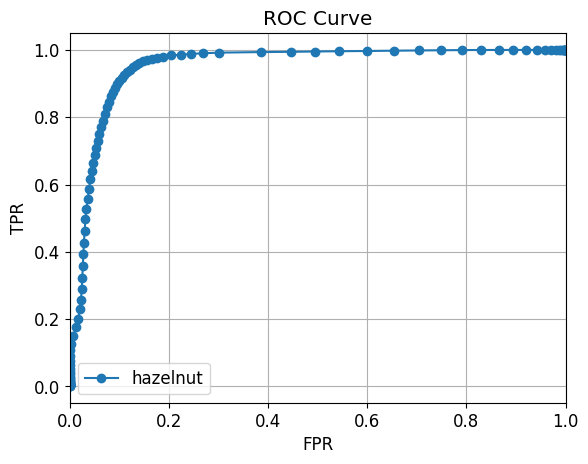

In [ ]:
plot_ROC_curve(datasets=datasets, results=results)

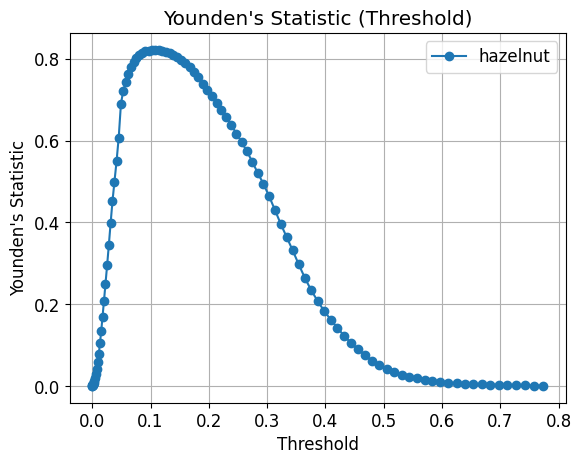

In [ ]:
plot_YoundStat_thresh(datasets=datasets, results=results)


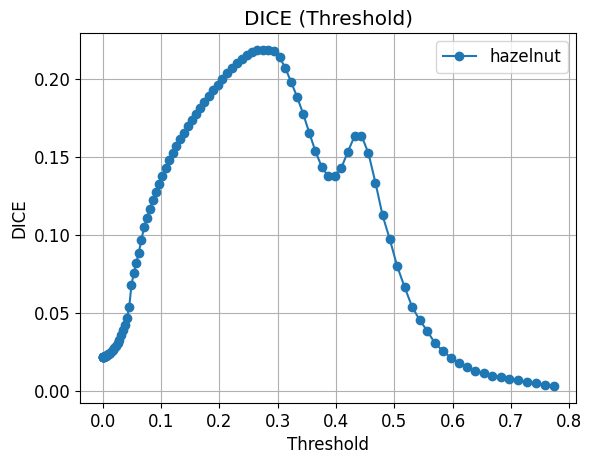

In [ ]:
plot_DICE_thresh(datasets=datasets, results=results)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

datasets = [ "hazelnut"]
optimal_thresh = 0.1
def evaluate_anomaly_classification(dataset_name, optimal_thresh, anomaly_percentage_threshold=0.05, results_dir="results"):
    # Create directories if not exist
    try:
        os.makedirs(f"{results_dir}/{dataset_name}/classified/")
    except:
        pass

    # Read original and predicted images
    img_oryg_samples, img_predict_samples, ground_truth_samples = read_data_test(dataset=dataset_name)

    # Calculate loss
    loss_samples = calculate_loss(img_oryg_samples=img_oryg_samples, img_predict_samples=img_predict_samples, win_size=11)

    # Evaluate anomaly classification
    for i in range(len(loss_samples)):
        predicted_mask = (loss_samples[i] > optimal_thresh).astype(int)
        ground_truth = ground_truth_samples[i]
        img_name = os.listdir(f"MVTEC/{dataset_name}/test/")[i]

        # Classify image based on anomaly percentage threshold
        anomaly_percentage = np.sum(predicted_mask) / predicted_mask.size
        classified_label = "normal" if anomaly_percentage <= anomaly_percentage_threshold else "anomaly"


        # Calculate classification metrics
        accuracy = accuracy_score(ground_truth.flatten(), predicted_mask.flatten())
        precision = precision_score(ground_truth.flatten(), predicted_mask.flatten())
        recall = recall_score(ground_truth.flatten(), predicted_mask.flatten())
        f1 = f1_score(ground_truth.flatten(), predicted_mask.flatten())

        # Print or save the metrics
        print(f"Image: {img_name}")
        print(f"Anomaly Percentage: {anomaly_percentage:.4f}")
        print(f"Classified Label: {classified_label}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Optionally, print or save the confusion matrix
        conf_matrix = confusion_matrix(ground_truth.flatten(), predicted_mask.flatten())
        print("Confusion Matrix:")
        print(conf_matrix)

# Example usage
for dataset in datasets:
    evaluate_anomaly_classification(dataset_name=dataset, optimal_thresh=optimal_thresh, anomaly_percentage_threshold=0.05)


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Image: print
Anomaly Percentage: 0.1303
Classified Label: anomaly
Accuracy: 0.8872
Precision: 0.1409
Recall: 0.9551
F1 Score: 0.2456
Confusion Matrix:
[[911012 117400]
 [   906  19258]]
Image: cut
Anomaly Percentage: 0.1378
Classified Label: anomaly
Accuracy: 0.8657
Precision: 0.0271
Recall: 0.9383
F1 Score: 0.0526
Confusion Matrix:
[[903865 140543]
 [   257   3911]]
Image: hole
Anomaly Percentage: 0.1595
Classified Label: anomaly
Accuracy: 0.8456
Precision: 0.0323
Recall: 0.9800
F1 Score: 0.0625
Confusion Matrix:
[[881255 161810]
 [   110   5401]]
Image: good
Anomaly Percentage: 0.1452
Classified Label: anomaly
Accuracy: 0.8702
Precision: 0.1070
Recall: 0.9899
F1 Score: 0.1931
Confusion Matrix:
[[896179 135941]
 [   167  16289]]
